# aim: comparer dS at the surface between daily and hourly data.

In [1]:
## standart libraries
import os,sys
import numpy as np

# xarray
import xarray as xr

# plot
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [2]:
from dask.distributed import Client
c = Client()
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42327,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:33697,Total threads: 4
Dashboard: http://127.0.0.1:41103/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:39455,


# setting constant variables

In [3]:
chunk_size = {"x":800,"y":700}

In [5]:
prefix = "eORCA025.L75-IMHOTEP"
nexpREF = "GAI"   
diridatref="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpREF+"-S/"

In [6]:
### for time_counter coordinate in MONTH
sshfilesGAI = diridatref+"1m"+"/????/"+prefix+"."+nexpREF+"*gridTsurf.nc"
sshGAI = xr.open_mfdataset(sshfilesGAI, chunks=chunk_size, parallel=True)

KeyboardInterrupt: 

In [7]:
########----------------- initialisation
# years to read data from:
y1=1980
y2=2019
nbmonthsts = (y2-y1)*12

2024-02-09 11:09:05,332 - distributed.nanny - WARNING - Restarting worker
2024-02-09 11:09:05,384 - distributed.nanny - WARNING - Restarting worker
2024-02-09 11:09:05,388 - distributed.nanny - WARNING - Restarting worker
2024-02-09 11:09:05,465 - distributed.nanny - WARNING - Restarting worker
2024-02-09 11:09:05,516 - distributed.nanny - WARNING - Restarting worker


# DAILY data

In [7]:
%%time
file = diridatref+"/1d/????-concat/eORCA025.L75-IMHOTEP."+nexpREF+"_y*_1d_gridTsurf.nc"

ds_T1d = xr.open_mfdataset(file,chunks = {"time_counter":2}, parallel=True).squeeze().sosaline

CPU times: user 6.94 s, sys: 292 ms, total: 7.23 s
Wall time: 16.3 s


In [8]:
#take only the first day of the month
first_day = ds_T1d.isel(time_counter=ds_T1d.time_counter.dt.day==1)

# compute deltaS = first day of the following month - first day if the current month
deltaS = (first_day.roll(time_counter=-1) - first_day) # garder en tete que le dernier point n'est pas bon


In [ ]:
# compute delta t in secondes
deltat = (first_day.time_counter.roll(time_counter=-1) - first_day.time_counter)*1e-9 # garder en tete que le dernier point n'est pas bon

# compute dS/dt
dSdt1d = deltaS / deltat.astype("float")

In [14]:
%%time
dSdt1dcomp = dSdt1d.compute()

CPU times: user 51.6 s, sys: 14.3 s, total: 1min 5s
Wall time: 1min 18s


In [8]:
diro ='/gpfsscratch/rech/cli/uor98hu/BILANS/GAI/reviews/'

In [15]:
dSdt1dcomp.to_dataset(name='sosaline').to_netcdf(path = diro+"GAI_dSdt_surf_1d.nc", mode='w')

In [ ]:
# saving of dS:
dS1dcomp = deltaS.compute()

In [9]:
dS1dcomp.to_dataset(name='sosaline').to_netcdf(path = diro+"GAI_dS_surf_1d.nc", mode='w')

# HOURLY data

In [5]:
%%time
file = diridatref+"/1h/????-concat/eORCA025.L75-IMHOTEP."+nexpREF+"_y*_1h_gridTsurf.nc"

ds_T1h = xr.open_mfdataset(file,chunks = {"time_counter":2}, parallel=True).squeeze().sosaline

CPU times: user 20.9 s, sys: 4.38 s, total: 25.3 s
Wall time: 38.1 s


In [6]:
#take only the first day of the month
first_day = ds_T1h.isel(time_counter=ds_T1h.time_counter.dt.day==1)
fisrt_hour = first_day.isel(time_counter=first_day.time_counter.dt.hour==0)

# compute deltaS = first day of the following month - first day if the current month
deltaS = (fisrt_hour.roll(time_counter=-1) - fisrt_hour) # garder en tete que le dernier point n'est pas bon

In [ ]:
# compute delta t in secondes
deltat = (fisrt_hour.time_counter.roll(time_counter=-1) - fisrt_hour.time_counter)*1e-9 # garder en tete que le dernier point n'est pas bon

# compute dS/dt
dSdt1d = deltaS / deltat.astype("float")


In [20]:
%%time
dSdt1dcomp = dSdt1d.compute()

CPU times: user 3min 23s, sys: 20 s, total: 3min 43s
Wall time: 4min 4s


In [7]:
diro ='/gpfsscratch/rech/cli/uor98hu/BILANS/GAI/reviews/'

In [21]:
dSdt1dcomp.to_dataset(name='sosaline').to_netcdf(path = diro+"GAI_dSdt_surf_1h.nc", mode='w')

In [8]:
# saving of dS:
dS1hcomp = deltaS.compute()

In [9]:
dS1hcomp.to_dataset(name='sosaline').to_netcdf(path = diro+"GAI_dS_surf_1h.nc", mode='w')

# PLOTS de vérification

In [35]:
# load data
diro = '/gpfsscratch/rech/cli/uor98hu/BILANS/GAI/reviews/'
### dS/dt
dSdt_1h = xr.open_dataset(diro+"GAI_dSdt_surf_1h.nc").sosaline
dSdt_1d = xr.open_dataset(diro+"GAI_dSdt_surf_1d.nc").sosaline


In [9]:
# load data
### dS
diro = '/gpfsscratch/rech/cli/uor98hu/BILANS/GAI/reviews/'
dS_1h = xr.open_dataset(diro+"GAI_dS_surf_1h.nc").sosaline
dS_1d = xr.open_dataset(diro+"GAI_dS_surf_1d.nc").sosaline

## Globally

In [11]:
# chunk_size = {"x":800,"y":700}
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh_hgr=xr.open_dataset(diri+'mesh_hgr.nc').squeeze()
tmask = mesh_hgr.tmask

e1t = mesh_hgr.e1t.fillna(0)
e2t = mesh_hgr.e2t.fillna(0)

# nav_lon =  mesh_hgr.nav_lon
# nav_lat =  mesh_hgr.nav_lat

bt = (e1t * e2t).load()# area of each cell
# getting the weights to be applied to every grid cell
# masking the land cells
oceanArea = (bt*tmask[0])  #tmask : 1 on ocean, 0 on land
totalOceanArea = oceanArea.sum()
Weight = (oceanArea/totalOceanArea).compute()

In [28]:
%%time
GM_dSdt_1h = (dSdt_1h * Weight).sum(('x','y')).compute()
GM_dSdt_1d = (dSdt_1d * Weight).sum(('x','y')).compute()


CPU times: user 9.07 s, sys: 9.32 s, total: 18.4 s
Wall time: 17.3 s


In [38]:
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/" # plot directory
namo = 'ts_exp1_Global_mean_dSdt_1h_vs_1d.jpg'

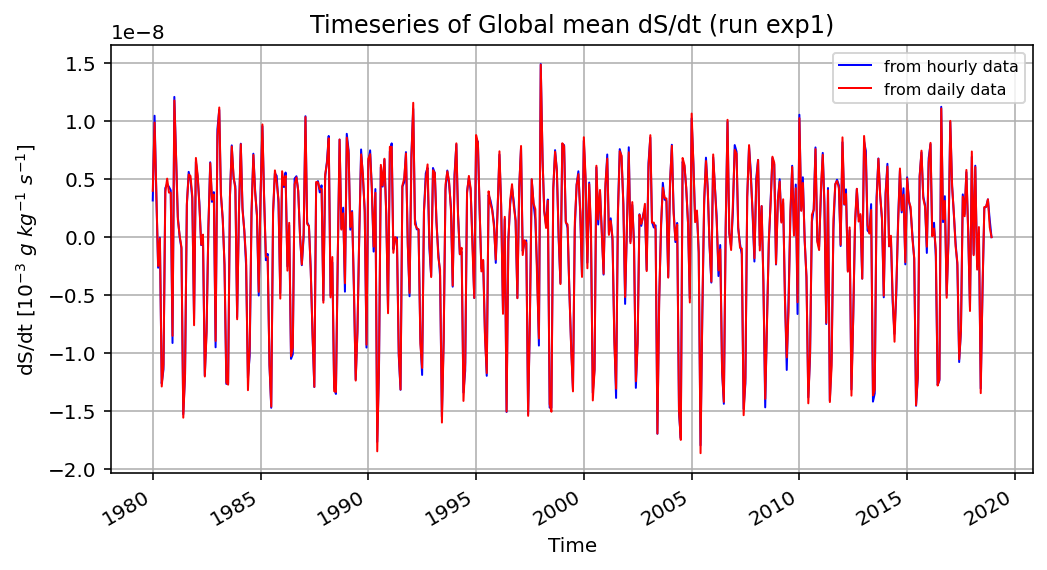

In [39]:
# plt.figure(figsize=(14,6))
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(21*cm, 10*cm), facecolor='none', dpi=72*2)

(GM_dSdt_1h).plot(color='b', linewidth=1)
(GM_dSdt_1d).plot(color='r', linewidth=1)

plt.legend(["from hourly data","from daily data"], fontsize=8)
plt.ylabel(r"dS/dt [$10^{-3}$ $g$ $kg^{-1}$ $s^{-1}$]")
plt.xlabel("Time")

plt.title("Timeseries of Global mean dS/dt (run exp1)")
plt.grid()
# plt.show()

fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight', transparent=True) #,edgecolor='none', bbox_inches='tight'


### en somme cummulée

In [12]:
%%time
GM_dS_1h = (dS_1h * Weight).sum(('x','y')).compute()
GM_dS_1d = (dS_1d * Weight).sum(('x','y')).compute()



CPU times: user 9.26 s, sys: 7.1 s, total: 16.4 s
Wall time: 15.3 s


In [15]:
GM_dS_1h_cumsum = GM_dS_1h.cumsum('time_counter')
GM_dS_1d_cumsum = GM_dS_1d.cumsum('time_counter')

In [16]:
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"

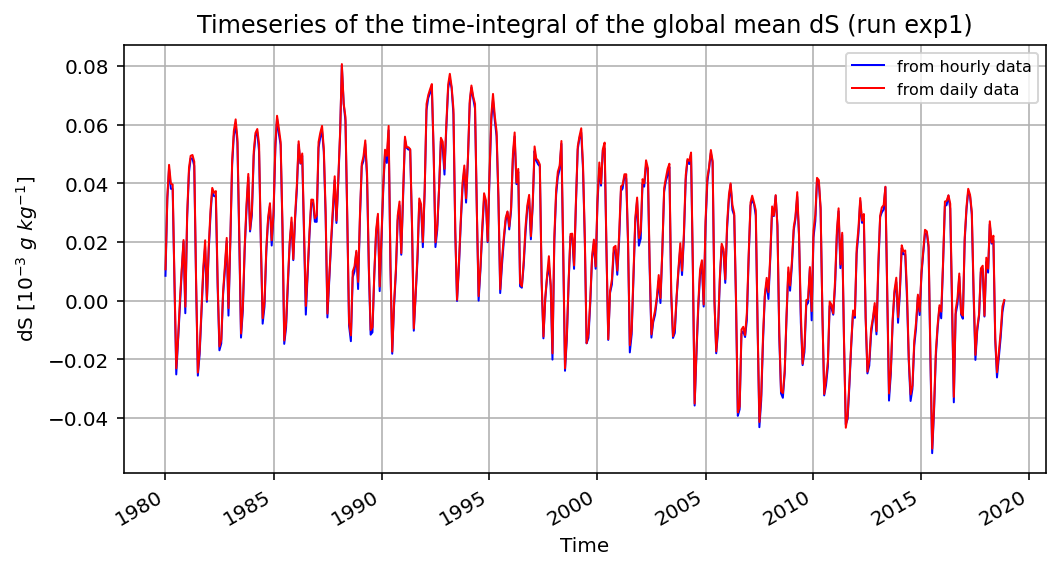

In [20]:
# plt.figure(figsize=(14,6))
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(21*cm, 10*cm), facecolor='none', dpi=72*2)

(GM_dS_1h_cumsum[:-1]).plot(color='b', linewidth=1)
(GM_dS_1d_cumsum[:-1]).plot(color='r', linewidth=1)

plt.legend(["from hourly data","from daily data"], fontsize=8)
plt.ylabel(r"dS [$10^{-3}$ $g$ $kg^{-1}$]")
plt.xlabel("Time")

plt.title("Timeseries of the time-integral of the global mean dS (run exp1)")
plt.grid()
# plt.show()

namo = 'ts_exp1_cumsum_Global_mean_dS_1h_vs_1d.jpg'

fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight', transparent=True) #,edgecolor='none', bbox_inches='tight'


## dans la gyre de Beaufort

### en time series de dS/dt

In [36]:
maskBG = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/TRANSPORT_WP1/BGRmaskobs.nc').BGRmask.squeeze()

BGR_dSdt_1h = dSdt_1h.where(maskBG,drop=True)
BGR_dSdt_1d = dSdt_1d.where(maskBG,drop=True)

# selecting the Beaufort Gyre box and doing the weighted mean over the box

btboxBG = bt.where(maskBG,drop=True)
tmaskboxBG = tmask.where(maskBG,drop=True)
oceanAreaBG = (btboxBG*tmaskboxBG[0])  #tmask : 1 on ocean, 0 on land
totalOceanAreaBG = oceanAreaBG.sum()
WeightboxBG = (oceanAreaBG / totalOceanAreaBG) #.compute()

BGR_dSdt_1h_mean = (BGR_dSdt_1h * WeightboxBG).sum(('x','y')).compute()
BGR_dSdt_1d_mean = (BGR_dSdt_1d * WeightboxBG).sum(('x','y')).compute()


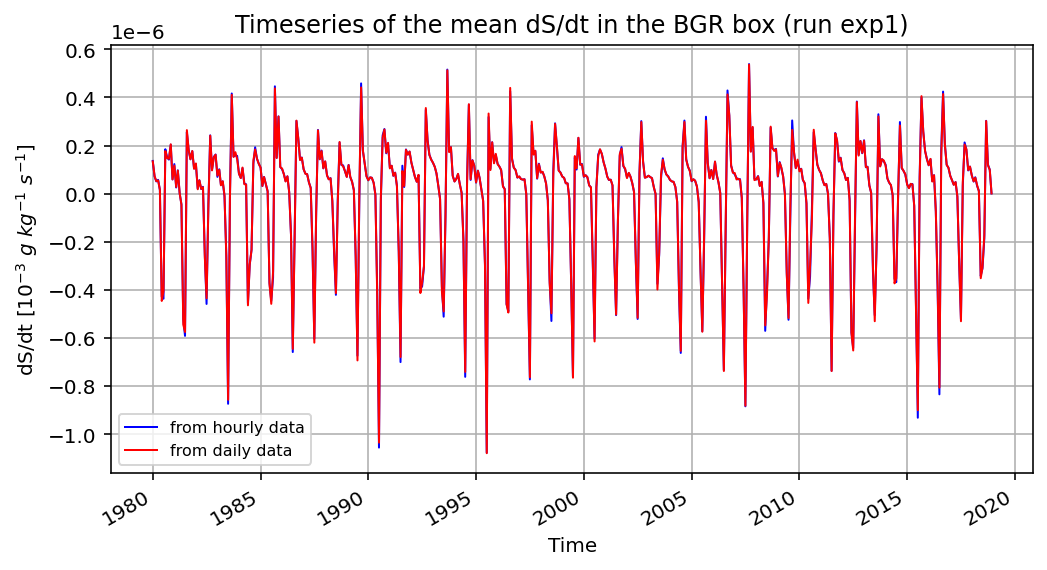

In [40]:
# plt.figure(figsize=(14,6))
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(21*cm, 10*cm), facecolor='none', dpi=72*2)

(BGR_dSdt_1h_mean).plot(color='b', linewidth=1)
(BGR_dSdt_1d_mean).plot(color='r', linewidth=1)

plt.legend(["from hourly data","from daily data"], fontsize=8)
plt.ylabel(r"dS/dt [$10^{-3}$ $g$ $kg^{-1}$ $s^{-1}$]")
plt.xlabel("Time")

plt.title("Timeseries of the mean dS/dt in the BGR box (run exp1)")
plt.grid()
# plt.show()

diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/" # plot directory

namo = 'ts_exp1_BGR_mean_dSdt_1h_vs_1d.jpg'
fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight', transparent=True) #,edgecolor='none', bbox_inches='tight'


### en somme cumulée

In [11]:
maskBG = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/TRANSPORT_WP1/BGRmaskobs.nc').BGRmask.squeeze()

BGR_dS_1h = dS_1h.where(maskBG,drop=True)
BGR_dS_1d = dS_1d.where(maskBG,drop=True)

# selecting the Beaufort Gyre box and doing the weighted mean over the box
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh_hgr=xr.open_dataset(diri+'mesh_hgr.nc').squeeze()
tmask = mesh_hgr.tmask

e1t = mesh_hgr.e1t.fillna(0)
e2t = mesh_hgr.e2t.fillna(0)

# nav_lon =  mesh_hgr.nav_lon
# nav_lat =  mesh_hgr.nav_lat

bt = (e1t * e2t).load()# area of each cell

btboxBG = bt.where(maskBG,drop=True)
tmaskboxBG = tmask.where(maskBG,drop=True)
oceanAreaBG = (btboxBG*tmaskboxBG[0])  #tmask : 1 on ocean, 0 on land
totalOceanAreaBG = oceanAreaBG.sum()
WeightboxBG = (oceanAreaBG / totalOceanAreaBG) #.compute()

BGR_dS_1h_mean = (BGR_dS_1h * WeightboxBG).sum(('x','y')).compute()
BGR_dS_1d_mean = (BGR_dS_1d * WeightboxBG).sum(('x','y')).compute()


In [12]:
BGR_dS_1h_mean_cumsum = BGR_dS_1h_mean.cumsum('time_counter')
BGR_dS_1d_mean_cumsum = BGR_dS_1d_mean.cumsum('time_counter')

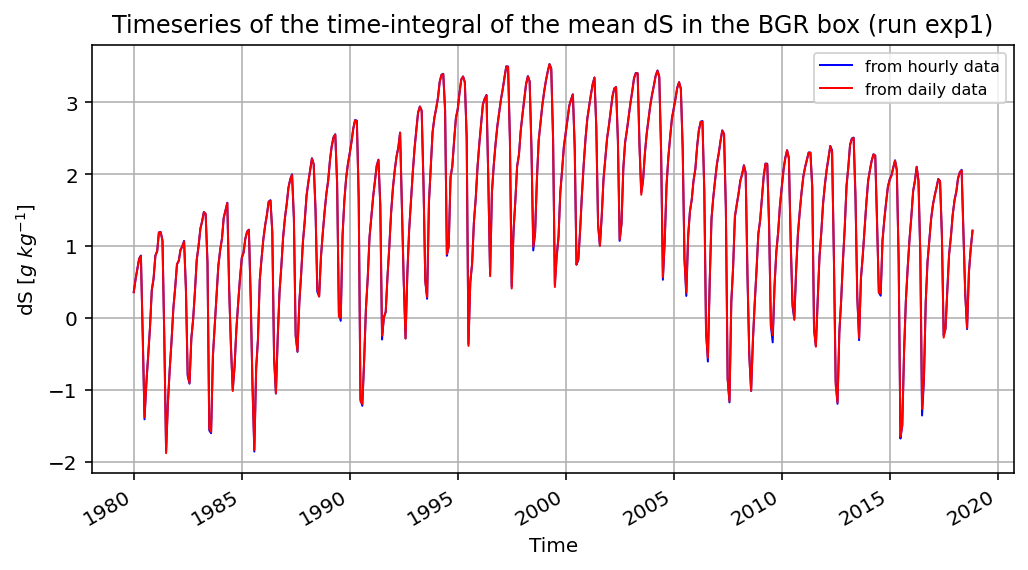

In [14]:
# plt.figure(figsize=(14,6))
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(21*cm, 10*cm), facecolor='none', dpi=72*2)

(BGR_dS_1h_mean_cumsum[:-1]).plot(color='b', linewidth=1)
(BGR_dS_1d_mean_cumsum[:-1]).plot(color='r', linewidth=1)

plt.legend(["from hourly data","from daily data"], fontsize=8)
plt.ylabel(r"dS [$g$ $kg^{-1}$]")
plt.xlabel("Time")

plt.title("Timeseries of the time-integral of the mean dS in the BGR box (run exp1)")
plt.grid()
# plt.show()

namo = 'ts_exp1_cumsum_BGR_mean_dS_1h_vs_1d.jpg'

fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight', transparent=True) #,edgecolor='none', bbox_inches='tight'


In [28]:
rel_err = abs( (BGR_dS_1d_mean_cumsum.assign_coords(time_counter=BGR_dS_1h_mean_cumsum.time_counter.data)[:-1] - BGR_dS_1h_mean_cumsum[:-1]) /BGR_dS_1h_mean_cumsum[:-1] )


In [31]:
rel_err.mean()*100

<xarray.DataArray ()>
array(2.40708287)
Coordinates:
    nav_lev  float32 0.5058

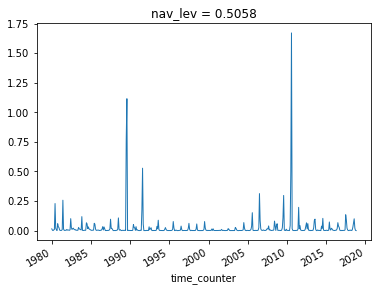

In [29]:
rel_err.plot( linewidth=1)
